In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import theano.tensor as tt
from theano import shared
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from pymc_utils import PyMCModel

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [37]:
def hs_regression(X, y_obs, ylabel='y', tau_0=None, regularized=False, **kwargs):
    """See Piironen & Vehtari, 2017 (DOI: 10.1214/17-EJS1337SI)"""
    if tau_0 is None:
        M = X.shape[1]
        m0 = M/2
        N = X.shape[0]
        tau_0 = m0 / ((M - m0) * np.sqrt(N))
    if regularized:
        slab_scale = kwargs.pop('slab_scale', 3)
        slab_scale_sq = slab_scale ** 2
        slab_df = kwargs.pop('slab_df', 8)
        half_slab_df = slab_df / 2
        with pm.Model() as mhsr:
            tau = pm.HalfCauchy('tau', tau_0)
            c_sq = pm.InverseGamma('c_sq', alpha=half_slab_df,
                                   beta=half_slab_df * slab_scale_sq)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            lamb_m_bar = tt.sqrt(c_sq) * lamb_m / (tt.sqrt(c_sq + 
                                                           tt.pow(tau, 2) *
                                                           tt.pow(lamb_m, 2)
                                                          )
                                                  )
            w = pm.Normal('w', mu=0, sd=tau*lamb_m_bar, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhsr
    else:
        with pm.Model() as mhs:
            tau = pm.HalfCauchy('tau', tau_0)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            w = pm.Normal('w', mu=0, sd = tau*lamb_m, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhs

    
def lasso_regression(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        bias = pm.Laplace('bias', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', bias + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def lasso_regr_impute_y(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlass_y_na:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        mu_y_obs = pm.Normal('mu_y_obs', 0.5, 1)
        sigma_y_obs = pm.HalfCauchy('sigma_y_obs', 1)
        y_obs_ = pm.Normal('y_obs', mu_y_obs, sigma_y_obs, observed=y_obs.squeeze())
        y = pm.Normal('y', mu=y_obs_, sd=sig)
    return mlass_y_na


def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def subset_significant_feature(trace, labels_list, beg_feat, alpha=0.05, vars_=None):
    if vars_ is None:
        vars_ = ['sd_beta', 'sigma', 'bias', 'w']
    dsum = pm.summary(trace, varnames=vars_, alpha=alpha)
    lbls_list = ['w[%s]' %lbl for lbl in labels_list]
    dsum.index = vars_[:-1] + lbls_list 
    hpd_lo, hpd_hi = 100 * (alpha / 2), 100 * (1 - alpha / 2)
    if str(hpd_lo).split('.')[1] == '0':
        hpd_lo = int(hpd_lo)
    if str(hpd_hi).split('.')[1] == '0':
        hpd_hi = int(hpd_hi)
    dsum_subset = dsum[(((dsum[f'hpd_{hpd_lo}']<0)&(dsum[f'hpd_{hpd_hi}']<0))|
                    ((dsum[f'hpd_{hpd_lo}']>0) & (dsum[f'hpd_{hpd_hi}']>0))
                   )]
    pattern1 = r'w\s*\[([a-z_\sA-Z0-9]+)\]'
    return list(dsum_subset.index.str.extract(pattern1).dropna().values.flatten())

In [4]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_noInteractions.pkl')

In [5]:
dps = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_MaxInteractions.pkl')

In [6]:
ds.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [7]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
X_s_na = ds.loc[:, feat_beg: feat_end_ni].values
lbls_X_s = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()

In [8]:
Xp_s = dps.dropna().loc[:, feat_beg: feat_end_wi].values
lbls_Xp_s = dps.loc[:, feat_beg: feat_end_wi].columns.tolist()
Xp_s_na = dps.loc[:, feat_beg: feat_end_wi].values

In [9]:
y = ds.dropna().log10_chl
y_na = ds.log10_chl

In [16]:
m_lasso_ = PyMCModel(lasso_regression, X_s, y, model_name='lasso_no_imp')
m_lasso_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:10<00:00, 989.13draws/s]


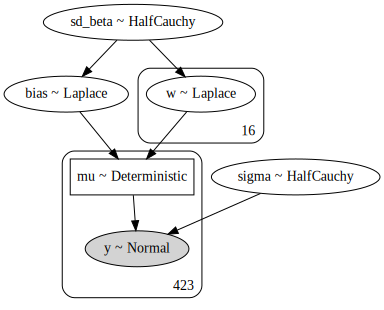

In [17]:
m_lasso_.show_model()

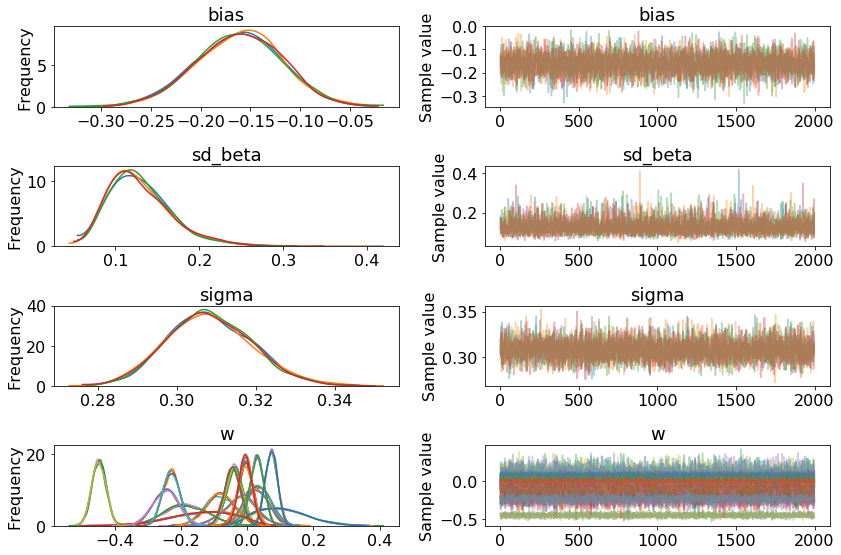

In [19]:
vars_ = ['bias', 'sd_beta', 'sigma', 'w',]
m_lasso_.evaluate_fit(show_feats=vars_);

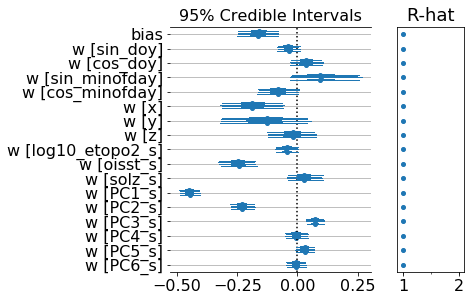

In [20]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_.show_forest(['bias', 'w'], feat_labels=lbls_list);

In [24]:
ypred = m_lasso_.predict(X_s).values

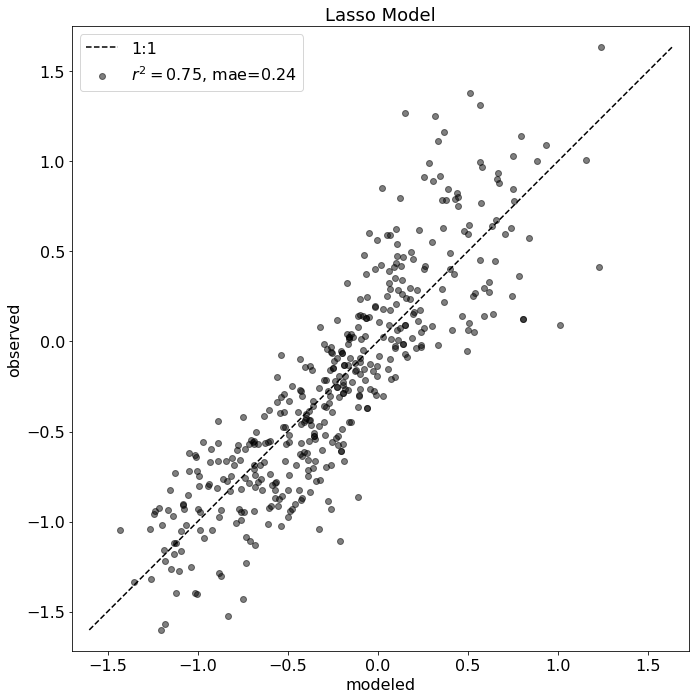

In [25]:
ax0 = m_lasso_.plot_model_fits(y_obs=y, y_pred=ypred, title='Lasso Model',
                               loss_metric='mae')

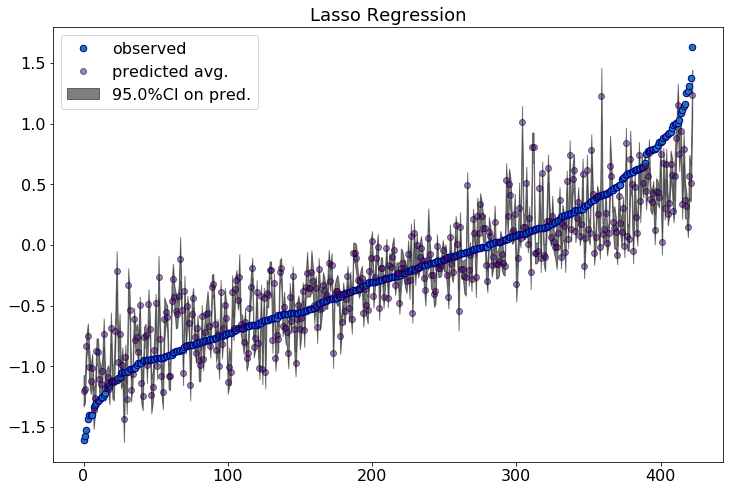

In [26]:
ax1 = m_lasso_.plot_model_fits2(y, ypred, title = 'Lasso Regression')

#### <u>2. with missing data imputation</u> 

In [27]:
m_lasso_na_ = PyMCModel(lasso_regression, X_s_na, y_na, model_name='lasso_w_imp')
m_lasso_na_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:14<00:00, 688.53draws/s]


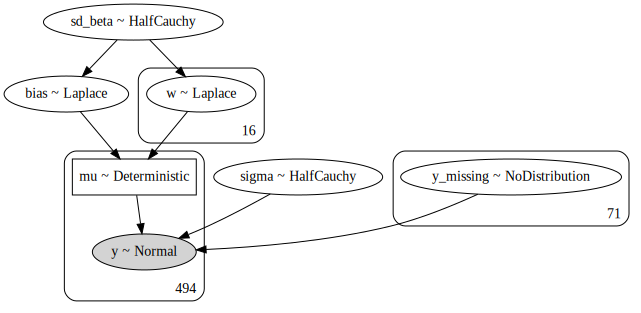

In [28]:
m_lasso_na_.show_model()

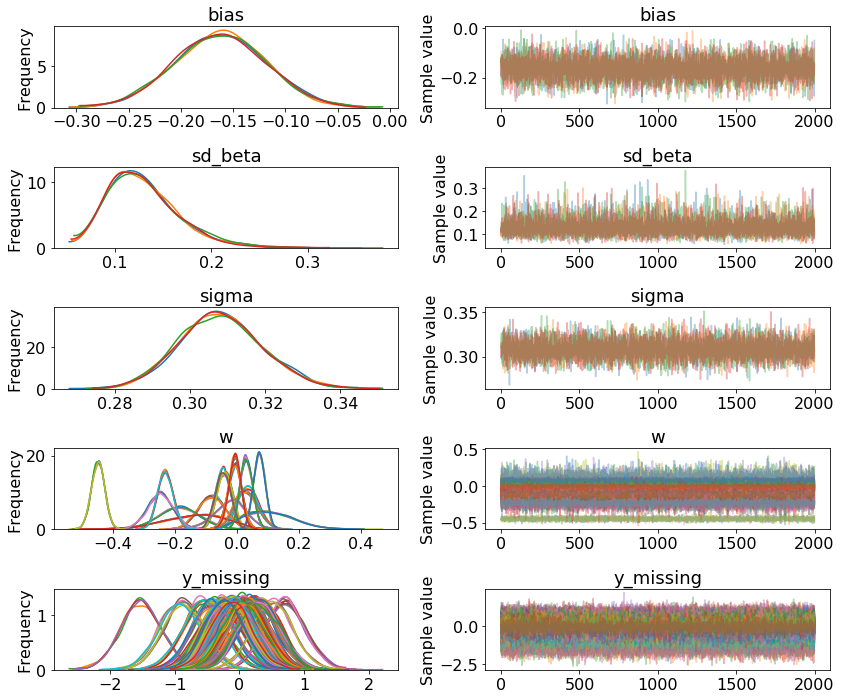

In [29]:
vars_na_ = vars_ + ['y_missing']
m_lasso_na_.evaluate_fit(vars_na_);

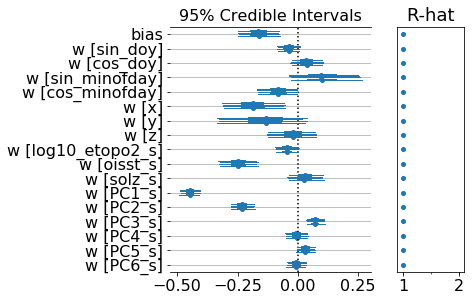

In [30]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_na_.show_forest(['bias', 'w'], feat_labels=lbls_list);

In [32]:
y_pred_na = m_lasso_na_.predict(X_s_na)

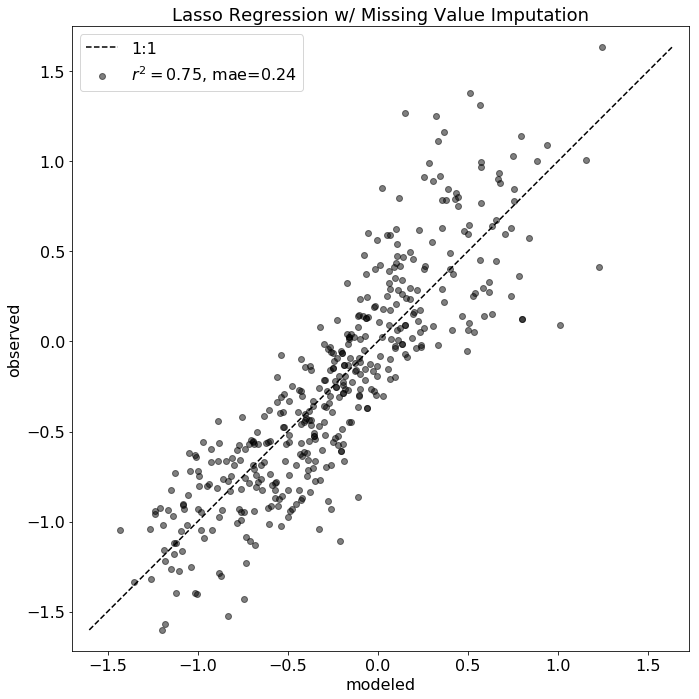

In [34]:
m_lasso_na_.plot_model_fits(y_obs=y_na, y_pred=y_pred_na, loss_metric='mae',
                            title='Lasso Regression w/ Missing Value Imputation');

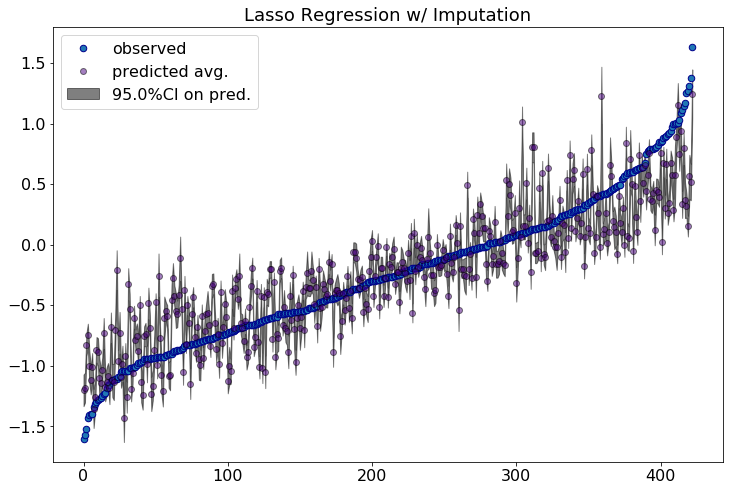

In [35]:
m_lasso_na_.plot_model_fits2(y_obs=y_na, y_pred=y_pred_na,
                            title="Lasso Regression w/ Imputation");

<u>Discover significant_features</u>

In [38]:
lasso_sub_feats = subset_significant_feature(m_lasso_na_.trace_,
                                             lbls_X_s, beg_feat=feat_beg)

In [39]:
lasso_sub_feats

['cos_minofday', 'x', 'oisst_s', 'PC1_s', 'PC2_s', 'PC3_s']

#### <u>3. With missing value imputation and subsetting of "significant features</u>

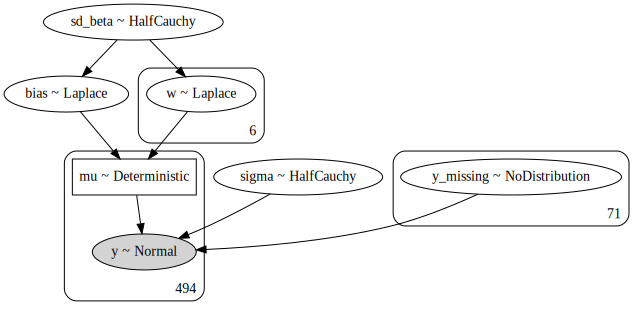

In [40]:
X_na_sub = ds.loc[:, lasso_sub_feats].values
mlasso_sub = PyMCModel(lasso_regression, X_na_sub, y_na,
                       model_name='lasso_regr_sub_w_imp')
mlasso_sub.show_model()

In [41]:
mlasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1506.15draws/s]


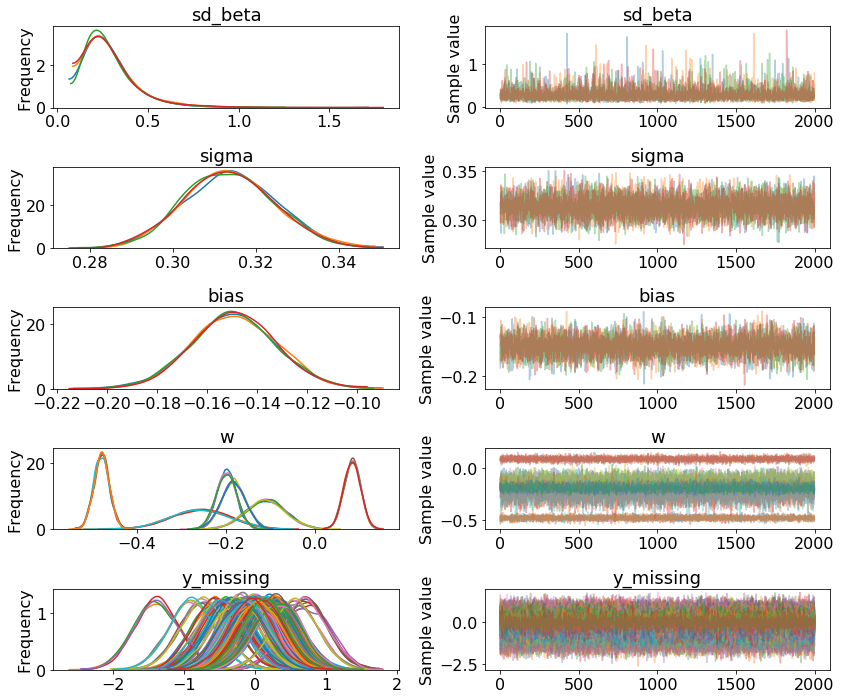

In [42]:
vars_ = ['sd_beta', 'sigma', 'bias', 'w', 'y_missing']
mlasso_sub.evaluate_fit(vars_);

In [43]:
y_pred_na_sub = mlasso_sub.predict(X_na_sub)

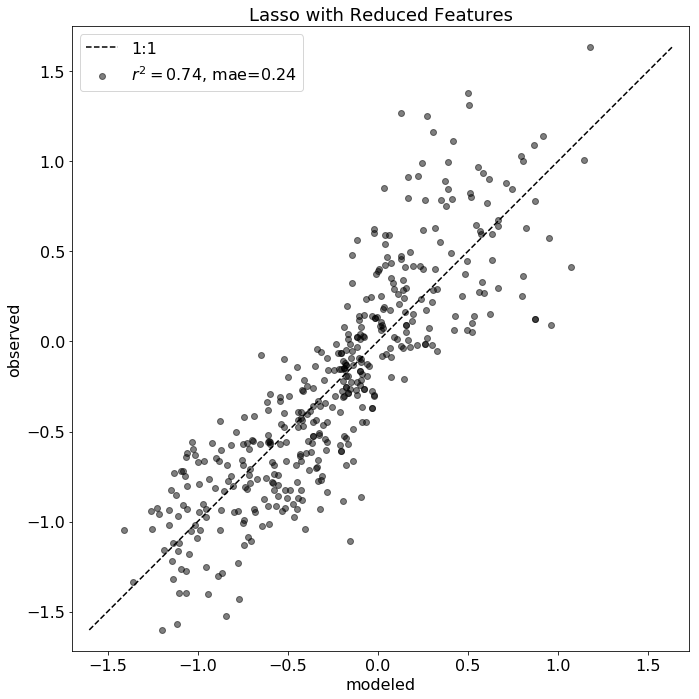

In [46]:
mlasso_sub.plot_model_fits(y_na, y_pred=y_pred_na_sub, loss_metric='mae',
                           title='Lasso with Reduced Features');

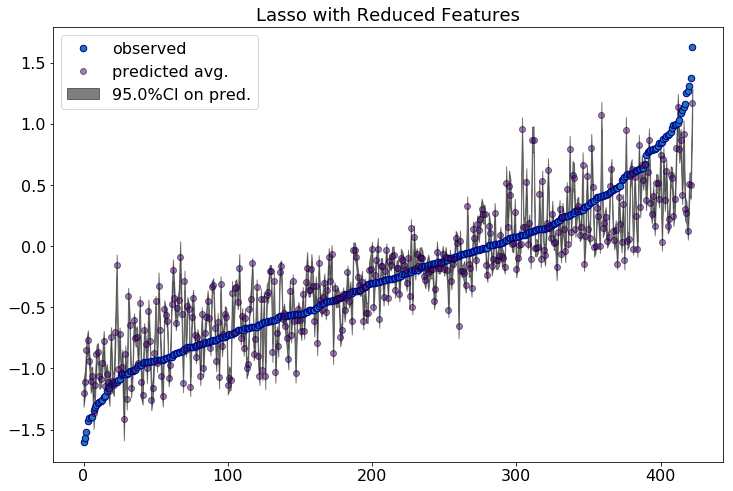

In [47]:
mlasso_sub.plot_model_fits2(y_na, y_pred_na_sub,
                            title='Lasso with Reduced Features');

### Modeling with Maximum Feature Interactions

#### <u>1. No missing value imputation</u>

In [48]:
mp_lasso = PyMCModel(lasso_regression, Xp_s, y, model_name='lasso_w_max_interactions')

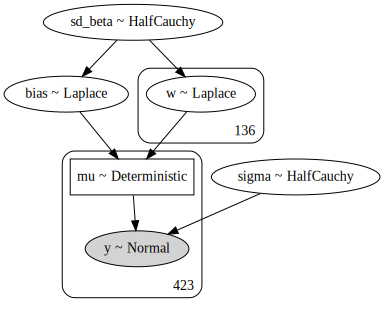

In [49]:
mp_lasso.show_model()

In [50]:
mp_lasso.fit_ADVI()

Average Loss = 114.72: 100%|██████████| 100000/100000 [01:02<00:00, 1590.09it/s]
Finished [100%]: Average Loss = 114.74


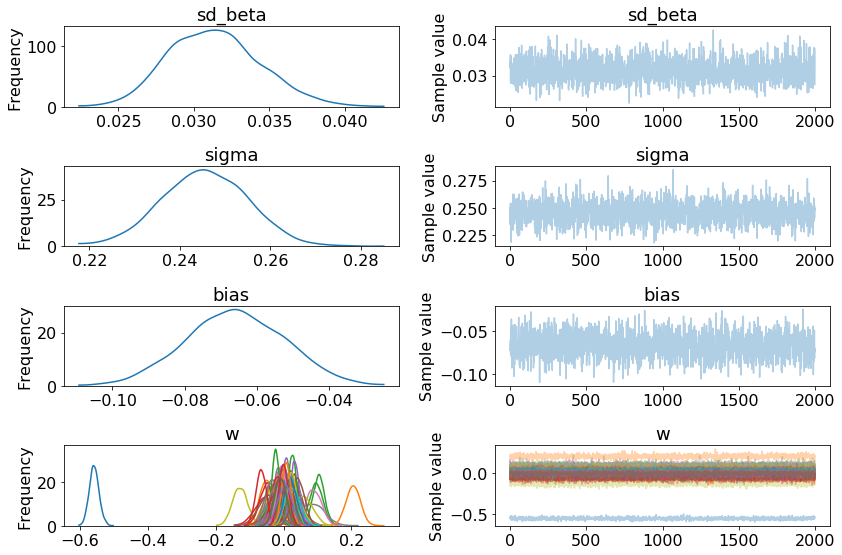

In [51]:
vars_ =['sd_beta', 'sigma', 'bias', 'w']
mp_lasso.evaluate_fit(vars_);

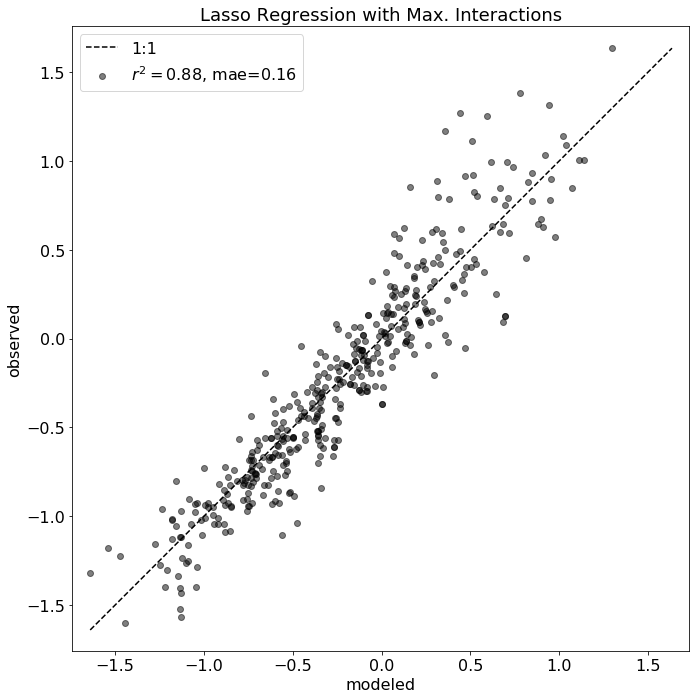

In [52]:
y_pred = mp_lasso.predict(Xp_s)
mp_lasso.plot_model_fits(y, y_pred=y_pred, loss_metric='mae',
                         title='Lasso Regression with Max. Interactions');

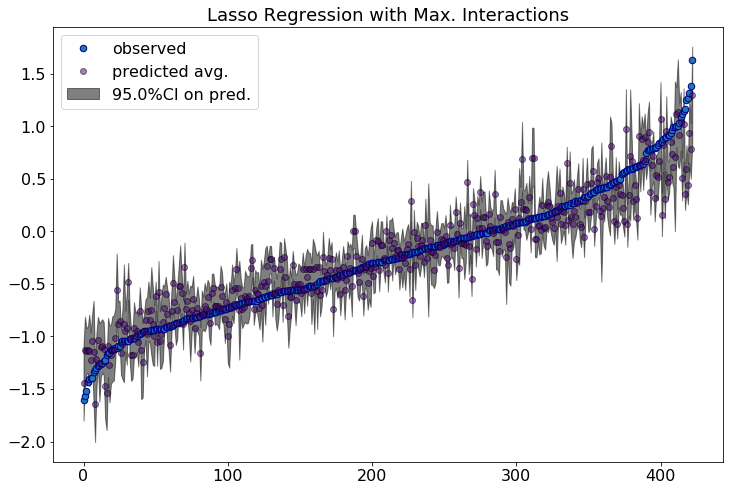

In [53]:
mp_lasso.plot_model_fits2(y, y_pred=y_pred,
                         title='Lasso Regression with Max. Interactions');

#### <u>2. with missing data imputation</u>

In [54]:
mp_lasso_na = PyMCModel(lasso_regression, Xp_s_na, y_na, 
                        model_name='lasso_w_max_inter_&_imp')

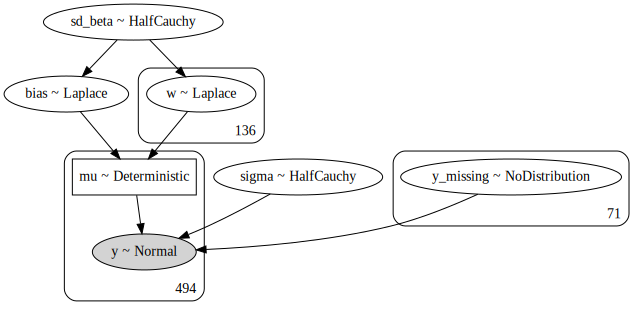

In [55]:
mp_lasso_na.show_model()

In [56]:
mp_lasso_na.fit_ADVI()

Average Loss = 121.74: 100%|██████████| 100000/100000 [01:06<00:00, 1498.10it/s]
Finished [100%]: Average Loss = 121.75


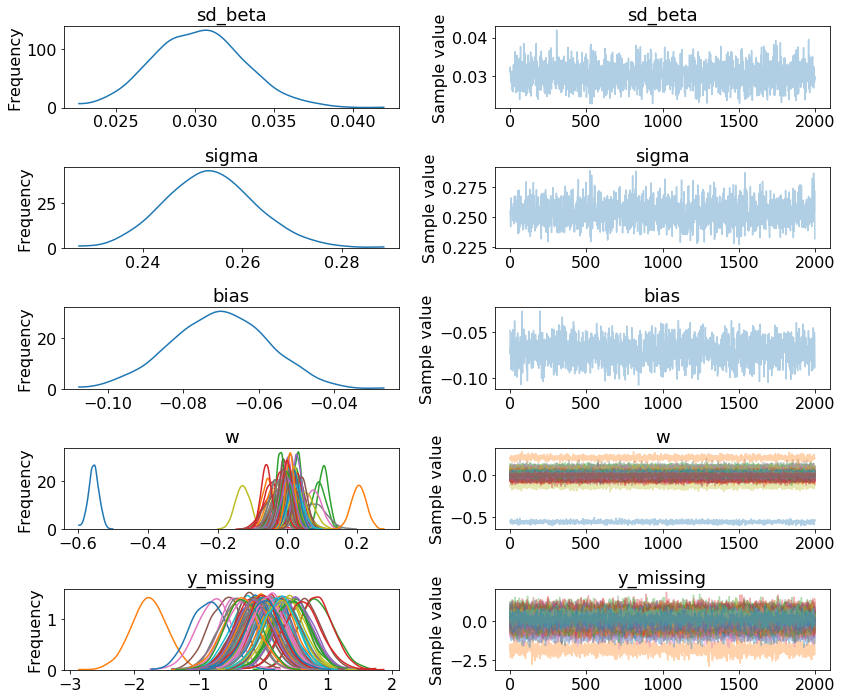

In [57]:
vars_ = vars_ =['sd_beta', 'sigma', 'bias', 'w', 'y_missing']
mp_lasso_na.evaluate_fit(vars_);

In [58]:
y_pred_p_na = mp_lasso_na.predict(Xp_s_na, )

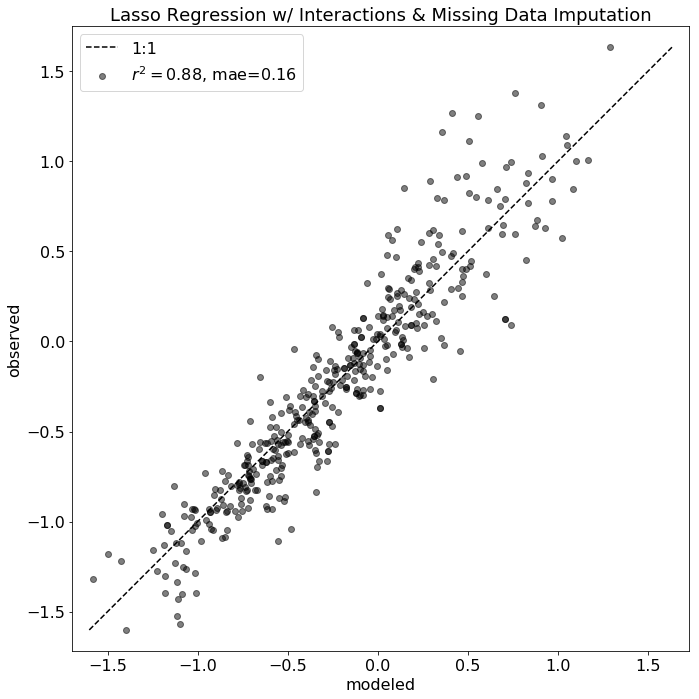

In [59]:
ttl = 'Lasso Regression w/ Interactions & Missing Data Imputation'
mp_lasso_na.plot_model_fits(y_na, y_pred=y_pred_p_na, loss_metric='mae',
                            title=ttl);

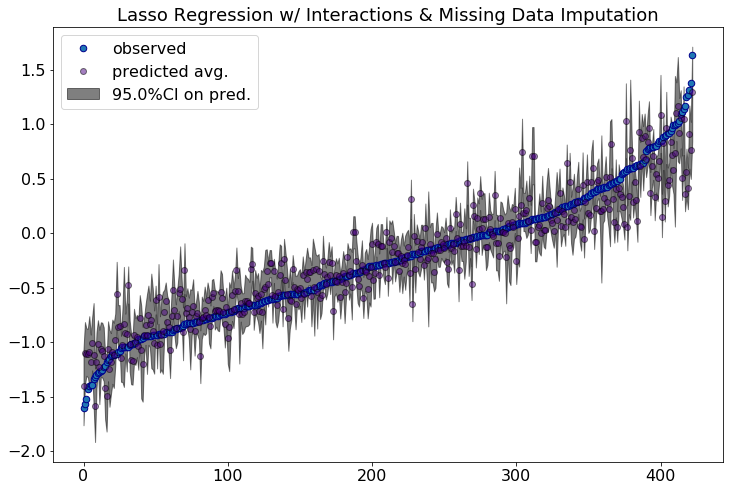

In [60]:
mp_lasso_na.plot_model_fits2(y_na, y_pred=y_pred_p_na, title=ttl);

#### <u>3. Subset significant features </u>

In [61]:
lasso_inter_sub_feats = subset_significant_feature(mp_lasso_na.trace_, 
                                                    lbls_Xp_s, feat_beg, alpha=0.1)

In [62]:
lasso_inter_sub_feats

['oisst_s',
 'PC1_s',
 'PC2_s',
 'PC3_s',
 'PC4_s',
 'sin_doy log10_etopo2_s',
 'sin_doy oisst_s',
 'cos_doy sin_minofday',
 'cos_doy PC5_s',
 'sin_minofday y',
 'x PC3_s',
 'y PC2_s',
 'log10_etopo2_s PC1_s',
 'log10_etopo2_s PC2_s',
 'log10_etopo2_s PC4_s',
 'log10_etopo2_s PC6_s',
 'oisst_s solz_s',
 'PC1_s PC2_s',
 'PC1_s PC3_s',
 'PC1_s PC4_s',
 'PC1_s PC5_s',
 'PC1_s PC6_s']

In [63]:
Xp_s_na_sub = dps.loc[:, lasso_inter_sub_feats].values
mp_lasso_na_sub = PyMCModel(lasso_regression, Xp_s_na_sub, y_na, 
                            model_name='lasso_regr_w_sub_inter_&_imp.')

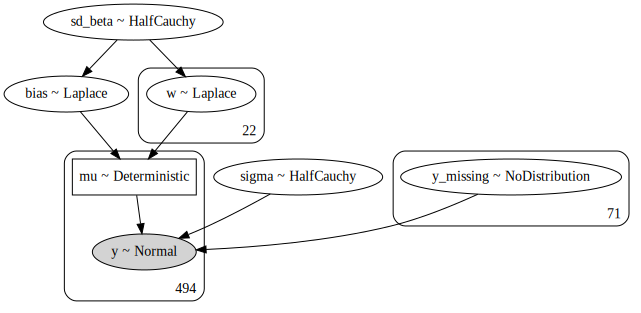

In [64]:
mp_lasso_na_sub.show_model()

In [65]:
mp_lasso_na_sub.fit_ADVI()

Average Loss = 57.379: 100%|██████████| 100000/100000 [00:57<00:00, 1741.75it/s]
Finished [100%]: Average Loss = 57.354


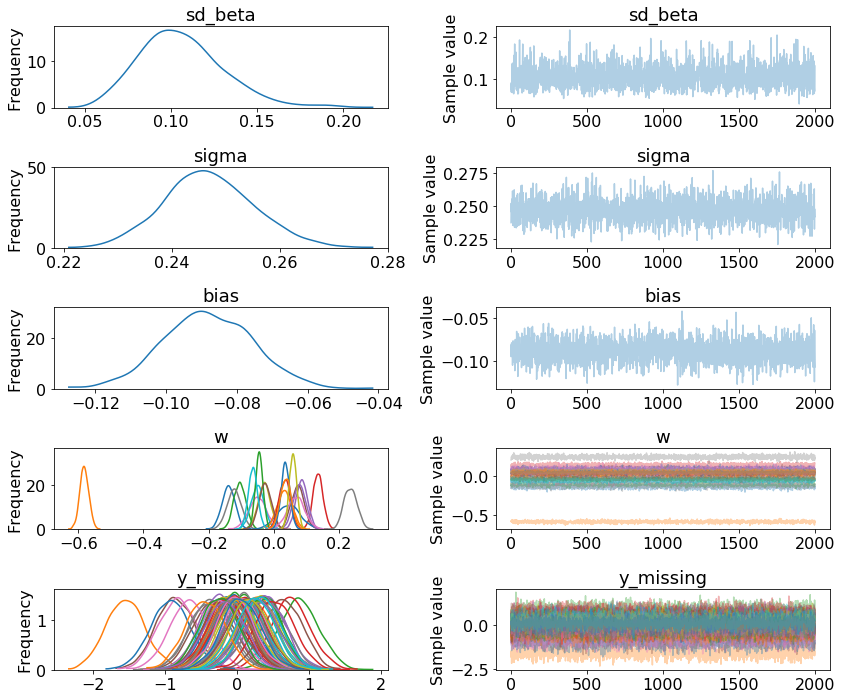

In [66]:
vars_ = ['sd_beta', 'sigma', 'bias', 'w', 'y_missing']
mp_lasso_na_sub.evaluate_fit(vars_);

In [67]:
y_pred_p_na_sub = mp_lasso_na_sub.predict(Xp_s_na_sub)

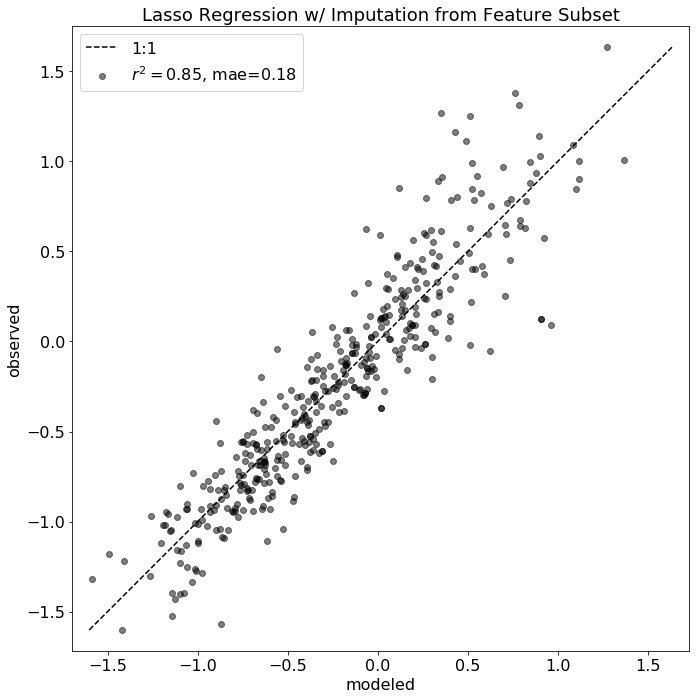

In [69]:
ttl = 'Lasso Regression w/ Imputation from Feature Subset'
mp_lasso_na_sub.plot_model_fits(y_na, y_pred=y_pred_p_na_sub, loss_metric='mae',
                                title=ttl);

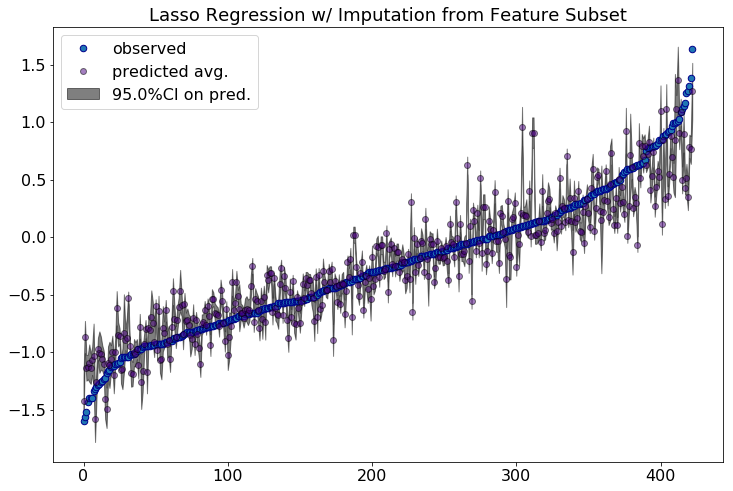

In [70]:
mp_lasso_na_sub.plot_model_fits2(y_na, y_pred=y_pred_p_na_sub, title=ttl);

In [72]:
mod_dict = {m_lasso_.model: m_lasso_.trace_,
            m_lasso_na_.model: m_lasso_na_.trace_,
            mlasso_sub.model: mlasso_sub.trace_,
            mp_lasso.model: mp_lasso.trace_,
            mp_lasso_na.model: mp_lasso_na.trace_,
            mp_lasso_na_sub.model: mp_lasso_na_sub.trace_,
           }
pm.compare(mod_dict)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
lasso_regr_w_sub_inter_&_imp.,35.35,29.17,0,0.97,38.52,0,1
lasso_w_max_inter_&_imp,123.97,87.77,88.63,0,36.69,16.74,1
lasso_w_max_interactions,156.38,109.6,121.04,0,40.42,20.15,1
lasso_w_imp,223.63,18.95,188.29,0.01,33.58,24.5,1
lasso_no_imp,223.65,18.87,188.3,0,33.51,24.46,1
lasso_regr_sub_w_imp,227.34,9.14,192,0.02,32.93,24.67,0


In [73]:
pm.compare(mod_dict, ic='LOO')

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
lasso_regr_w_sub_inter_&_imp.,42.65,32.82,0,0.96,39.34,0,1
lasso_w_max_inter_&_imp,162.24,106.9,119.58,0,41.98,21.31,1
lasso_w_imp,223.81,19.04,181.15,0.02,33.6,24.72,0
lasso_no_imp,223.9,19,181.25,0,33.55,24.68,0
lasso_w_max_interactions,224.19,143.5,181.54,0,52.48,32.98,1
lasso_regr_sub_w_imp,227.36,9.14,184.71,0.02,32.93,25.09,0


In [74]:
models_dict = {m_lasso_.model.name: m_lasso_,
               m_lasso_na_.model.name: m_lasso_na_,
               mlasso_sub.model.name: mlasso_sub,
               mp_lasso.model.name: mp_lasso,
               mp_lasso_na.model.name: mp_lasso_na,
               mp_lasso_na_sub.model.name: mp_lasso_na_sub,
              }
with open('./pickleJar/Models/pooled_models.pkl', 'wb') as f:
    pickle.dump(models_dict, f, protocol=pickle.HIGHEST_PROTOCOL)